# Load libraries & set constants

In [9]:
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

workspace_path = Path(os.getcwd()).parent
flavour = "test_balanced"

# Load SUMMIT data

************** Nodule Level XTab: actionable_nodule_count_cats **************



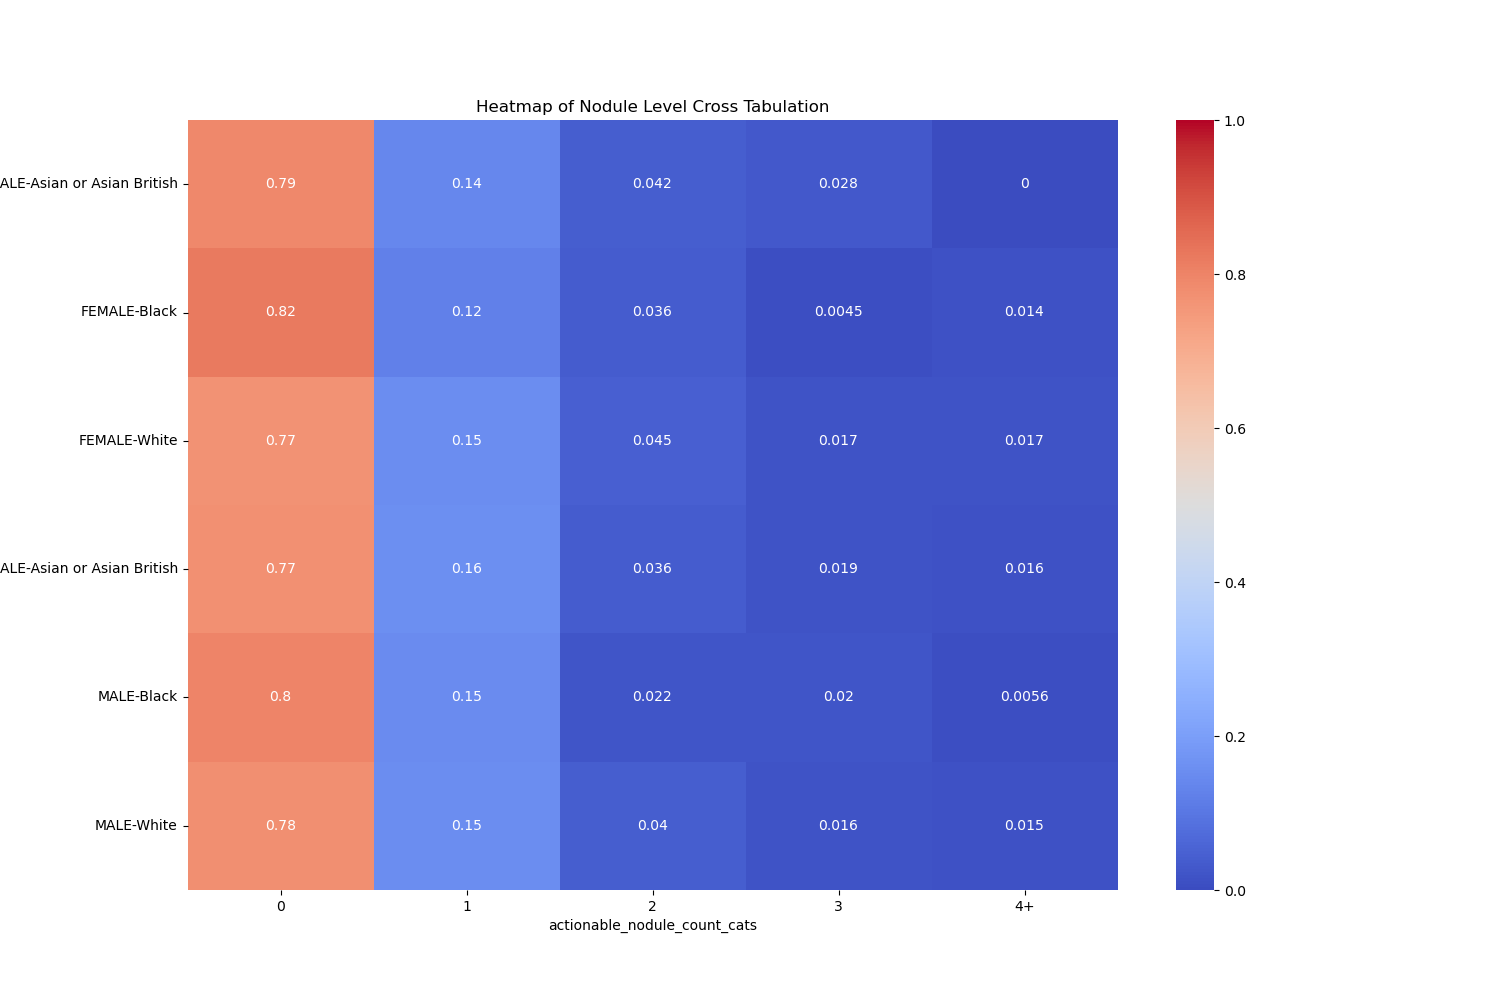

************** Nodule Level XTab: actionable_nodule_count_cats **************



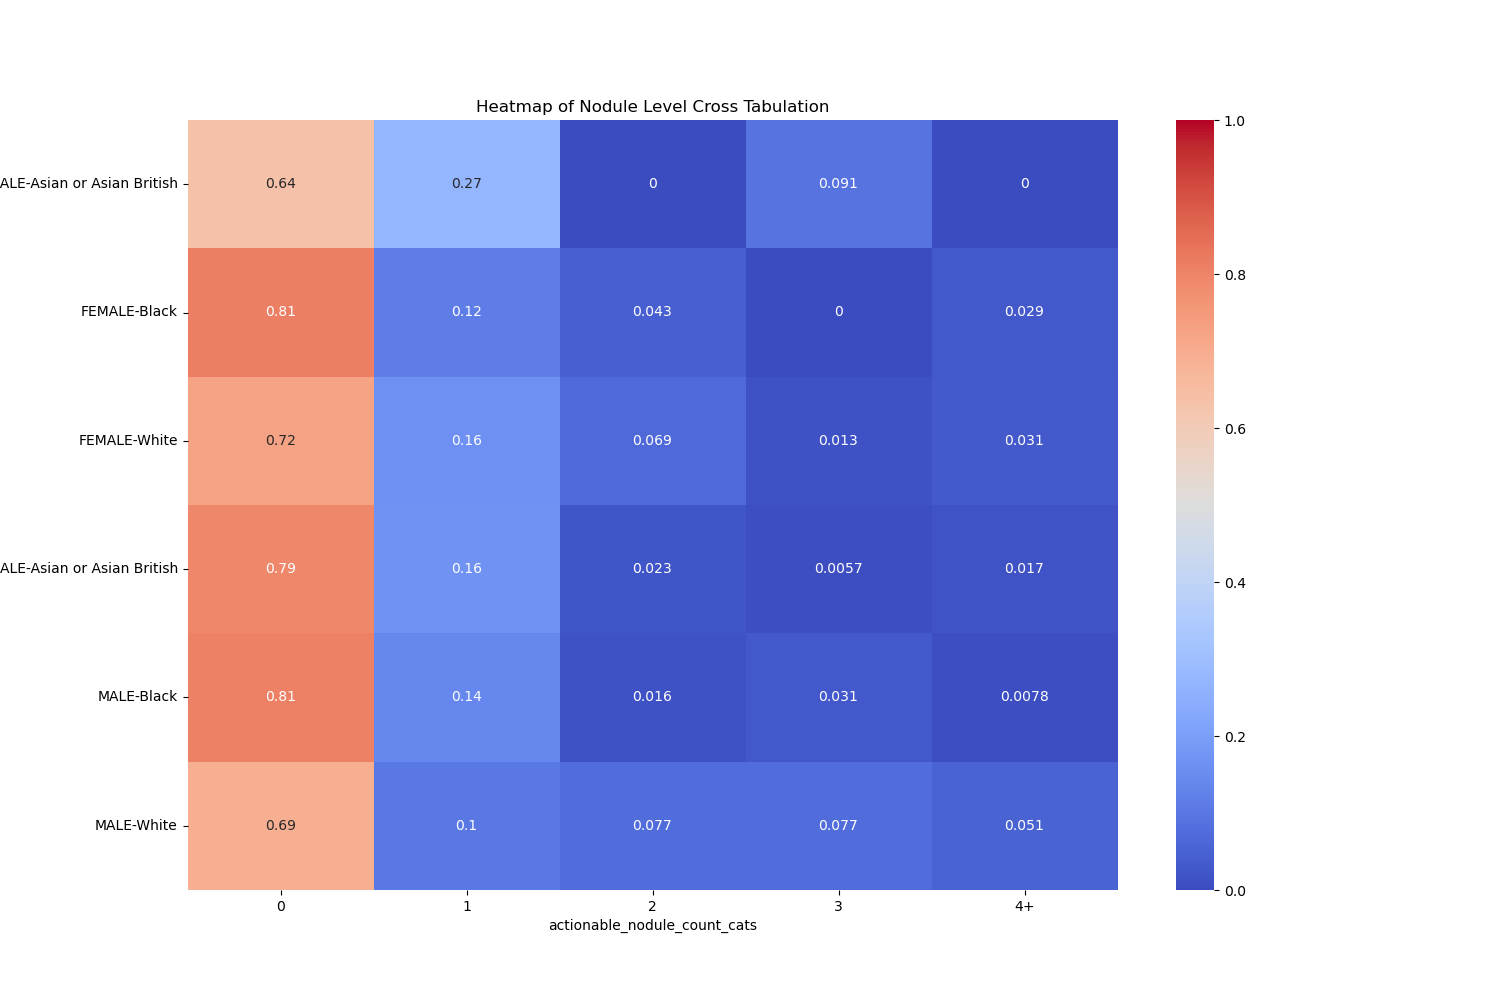

************** Nodule Level XTab: nodule_type **************


,CALCIFIED,NON_SOLID,PART_SOLID,SOLID,All,Scan Cnt
gender,,,,,,
FEMALE,392 (19.4%),513 (25.3%),258 (12.7%),862 (42.6%),2025,5261
MALE,428 (16.9%),451 (17.8%),247 (9.7%),1408 (55.6%),2534,6966

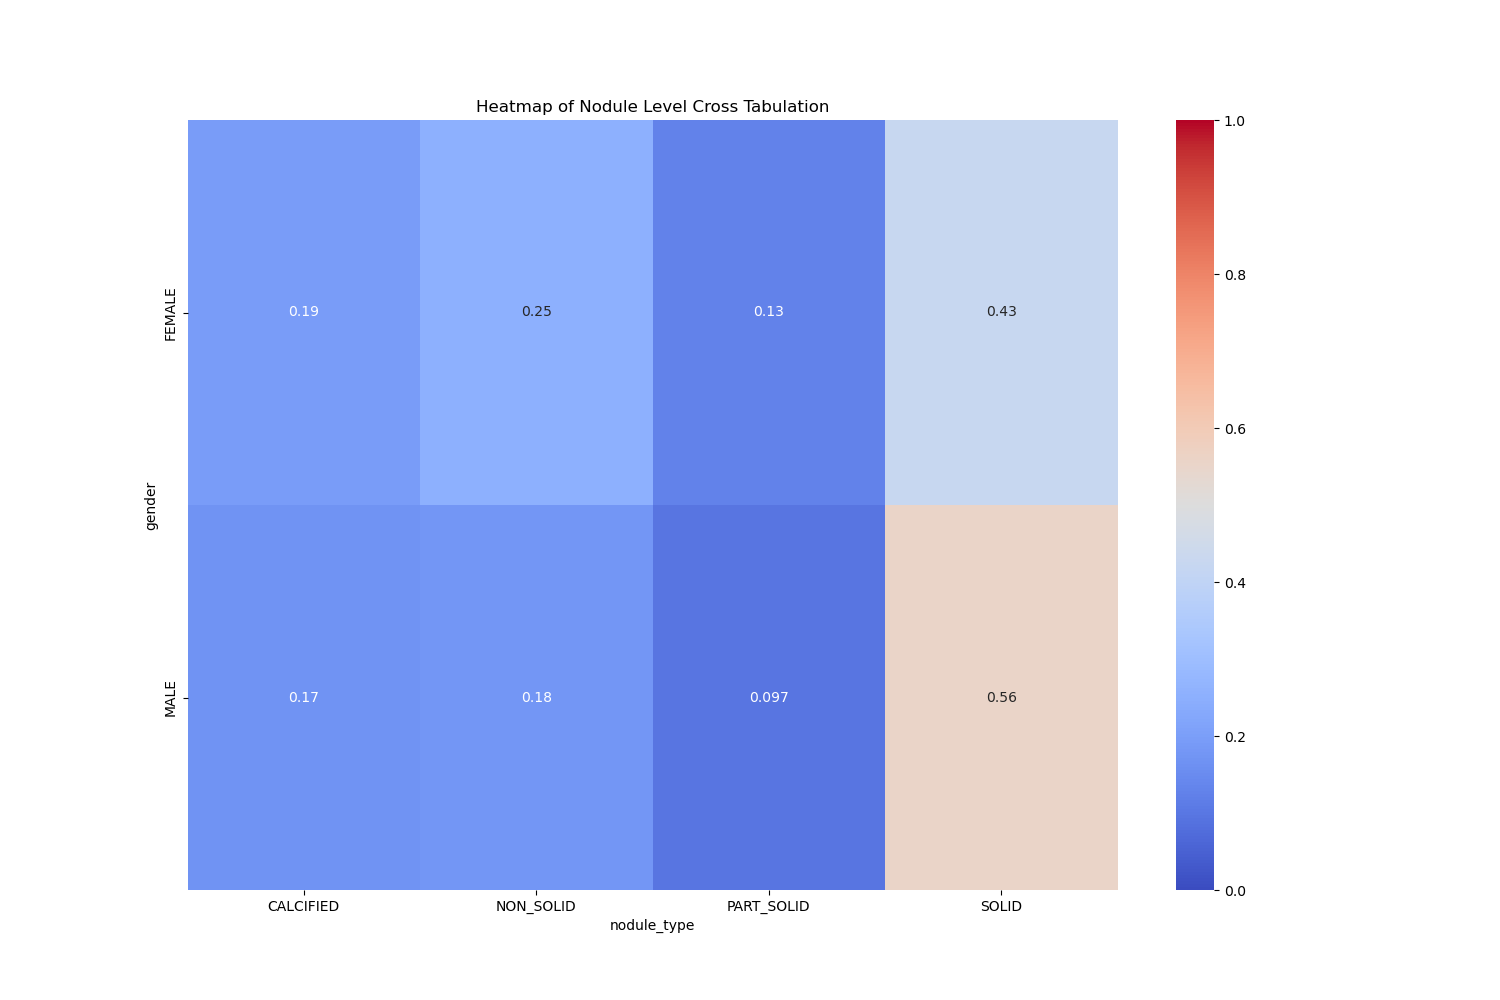

************** Nodule Level XTab: nodule_type **************


,CALCIFIED,NON_SOLID,PART_SOLID,SOLID,All,Scan Cnt
gender,,,,,,
FEMALE,25 (22.7%),18 (16.4%),16 (14.5%),51 (46.4%),110,250
MALE,16 (13.3%),25 (20.8%),9 (7.5%),70 (58.3%),120,344

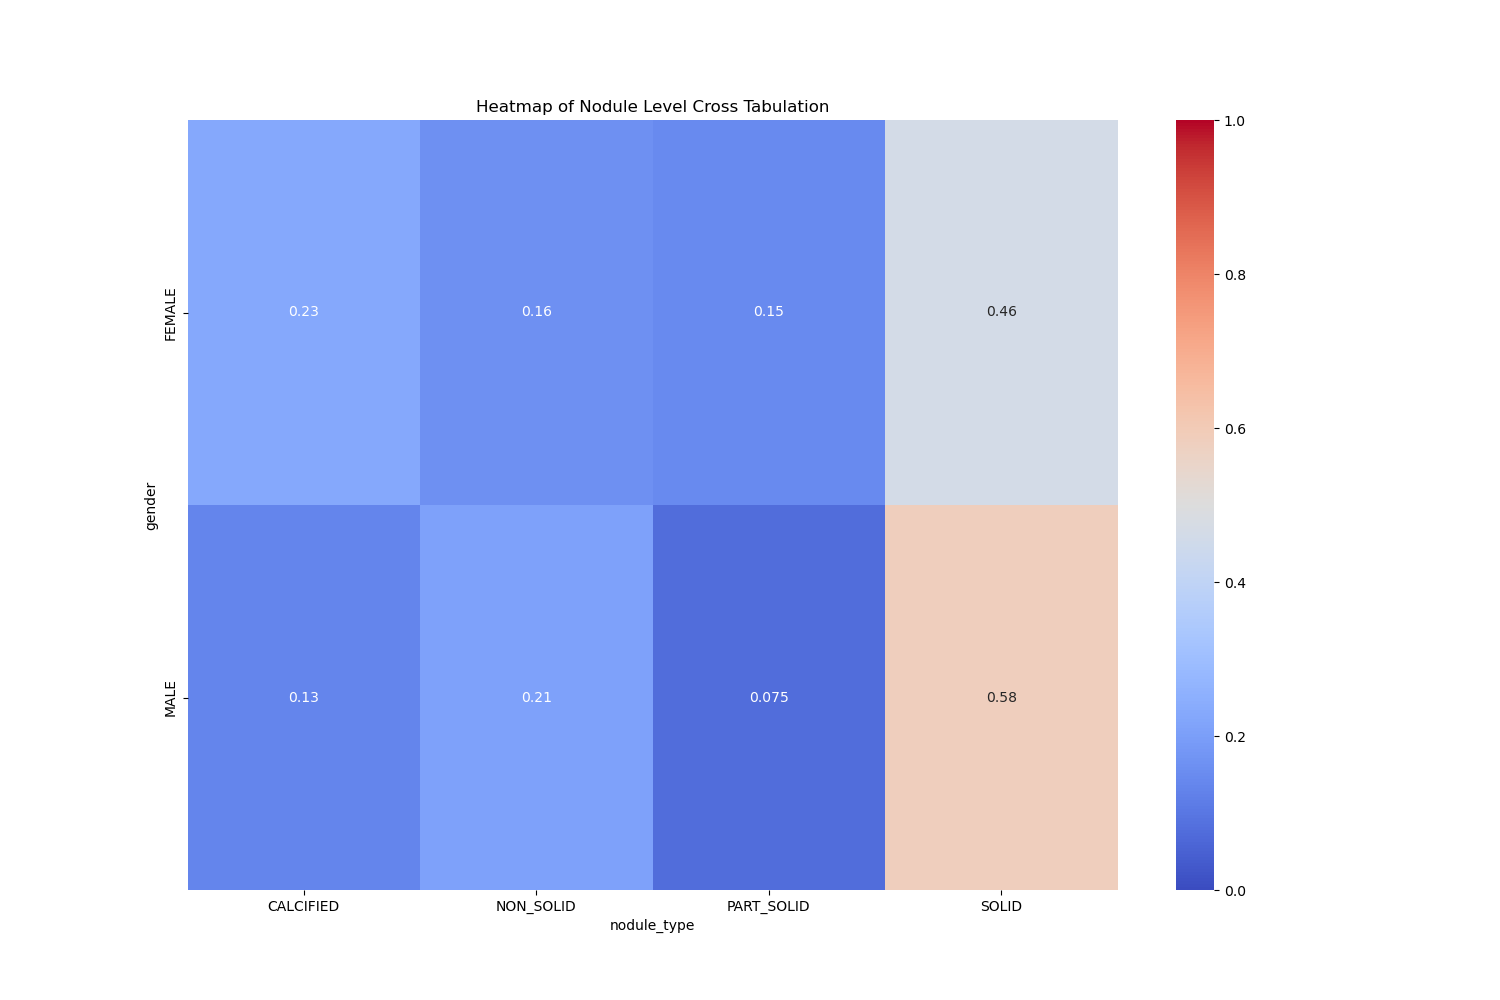

************** Nodule Level XTab: diameter_mm_cats **************



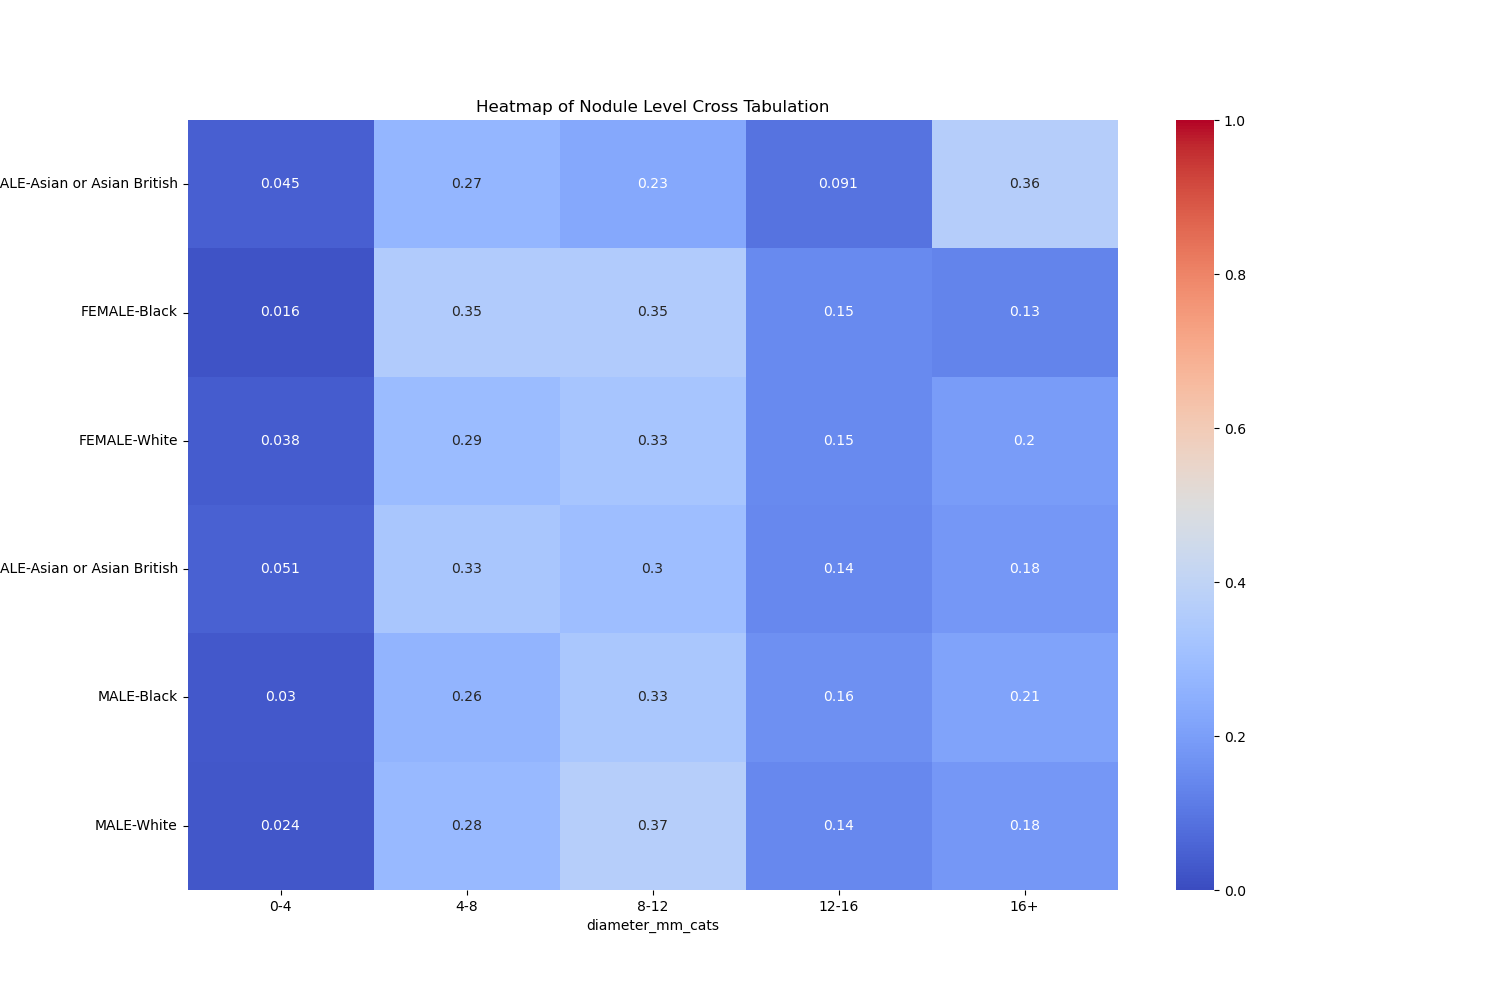

************** Nodule Level XTab: diameter_mm_cats **************



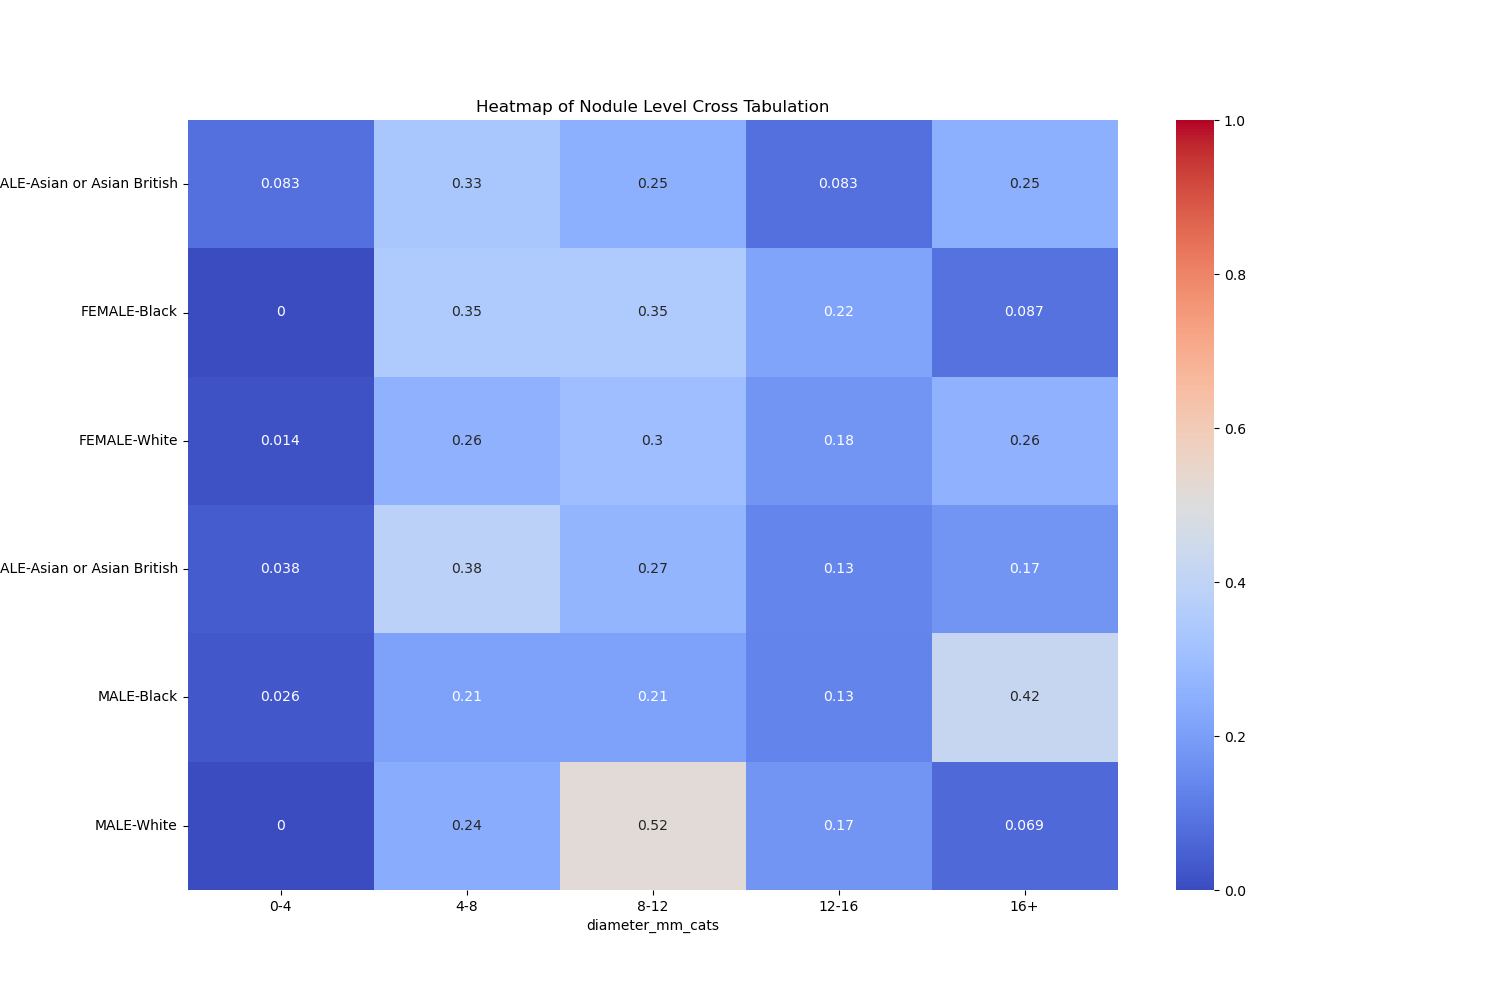

************** Nodule Level XTab: nodule_type_by_size **************



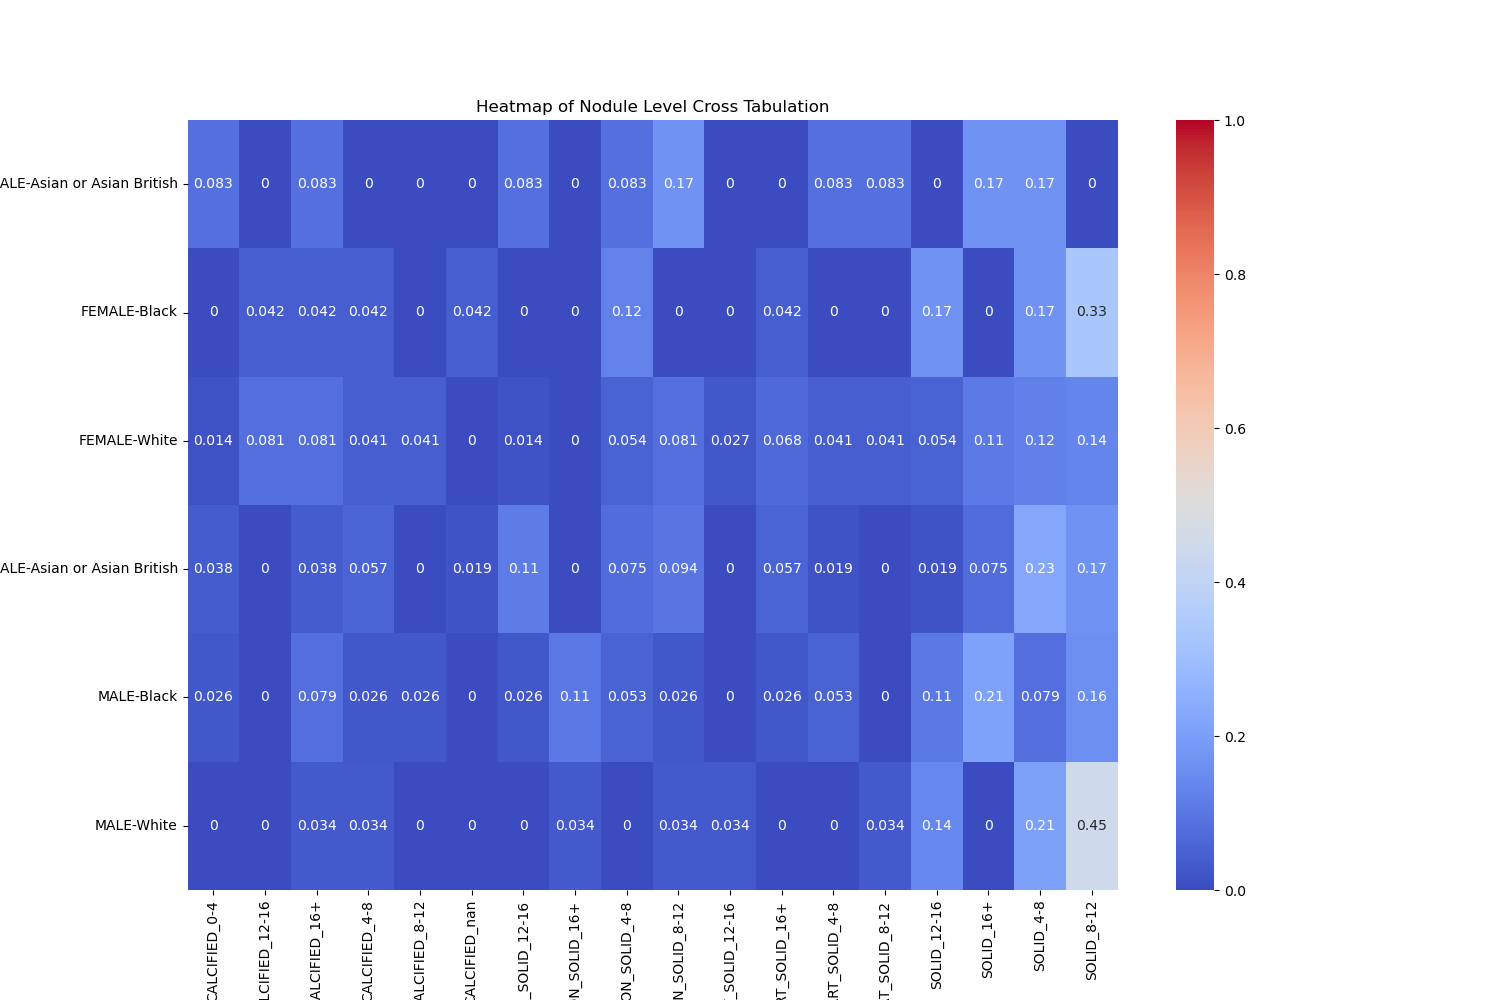

In [57]:
import base64
import io
from IPython.display import display, HTML
from sklearn import base

person_data = (
    pd.read_csv(workspace_path / "data" / "summit" / "data" / "person_data.csv",
        usecols=[
        'Y0_PARTICIPANT_DETAILS_main_participant_id', 
        'participant_details_gender',
        'lung_health_check_demographics_race_ethnicgroup'
    ])
    .rename(columns={
        'Y0_PARTICIPANT_DETAILS_main_participant_id': 'StudyId', 
        'participant_details_gender' : 'gender', 
        'lung_health_check_demographics_race_ethnicgroup' : 'ethnic_group'
    })
    .assign(name=lambda x: x['StudyId'] + '_Y0_BASELINE_A')
)

nodule_data = (
    pd.read_csv(workspace_path / "data" / "summit" / "data" / "nodule_data.csv",
                usecols=[
                'participant_id',
                'radiology_report_nodule_diameter_mm',
                'radiology_report_nodule_type',
                'radiology_report_management_plan',
                 'participant_details_gender',
                'lung_health_check_demographics_race_ethnicgroup'
                ])
    .rename(columns={
        'radiology_report_nodule_diameter_mm': 'diameter_mm',
        'radiology_report_nodule_type': 'nodule_type',
        'radiology_report_management_plan': 'management_plan',
        'participant_details_gender' : 'gender',
        'lung_health_check_demographics_race_ethnicgroup' : 'ethnic_group'
    })
    .assign(
        name=lambda x: x['participant_id'] + '_Y0_BASELINE_A',
        actionable=lambda x: x['management_plan'] != 'RANDOMISATION_AT_YEAR_1',
        diameter_mm_cats=lambda x: pd.cut(
            x['diameter_mm'],
            bins=[0, 4, 8, 12, 16, 999],
            labels=['0-4', '4-8', '8-12', '12-16', '16+']
        ),
        nodule_type_by_size=lambda x: x['nodule_type'] + '_' + x['diameter_mm_cats'].astype(str)
    ))

# Remove ENDOBRONCHIAL nodules
nodule_data = nodule_data.query('nodule_type != "ENDOBRONCHIAL"')

nodule_count = nodule_data.groupby('name').size().reset_index().rename(columns={0: 'nodule_count'})
actionable_nodule_count = nodule_data.query('management_plan != "RANDOMISATION_AT_YEAR_1"').groupby('name').size().reset_index().rename(columns={0: 'actionable_nodule_count'})

person_data = person_data.merge(nodule_count, on='name', how='left').fillna(0)
person_data = person_data.merge(actionable_nodule_count, on='name', how='left').fillna(0)

person_data['nodule_count_cats'] = pd.cut(
    person_data['nodule_count'], 
    bins=[-1, 0, 1, 2, 3, 4, 5, 6, 100],
    labels= ['0', '1', '2', '3', '4', '5', '6', '7+']
)

person_data['actionable_nodule_count_cats'] = pd.cut(
    person_data['actionable_nodule_count'],
    bins=[-1, 0, 1, 2, 3, 100],
    labels= ['0', '1', '2', '3', '4+']
)


test_scan_ids = pd.read_csv(workspace_path / 'metadata' / 'summit' / 'test_balanced' / 'test_scans.csv')['scan_id'].values


def gender_group_xtab(scans, data, var, table=True):
    x = pd.crosstab(
        [
            data['gender']
        ],
        data[var],
        margins='index',
    )
    p = pd.crosstab(
            [
                data['gender']
            ],
            data[var],
            margins=True,
            normalize='index'
        )
    
    scan_tot = pd.DataFrame(
        scans.
        groupby(['gender'])
        .size()
        .fillna(0)
        .astype(int)
    ).rename(columns={0: 'Scan Cnt'})

    print(f'************** Nodule Level XTab: {var} **************')    
    xtab = (
        (x.drop(columns=['All']).astype(str) + ' (' + p.applymap(lambda x: f"{x:.1%}") + ')')
        .merge(x['All'], left_index=True, right_index=True)
        .merge(scan_tot, left_index=True, right_index=True)
    )

    # display(xtab)

    # Combine the xtab and heatmap side by side
    if table:
        xtab_html = xtab.to_html()
        
        fig, ax = plt.subplots(figsize=(15, 10))
        sns.heatmap(p.drop('All'), annot=True, cmap='coolwarm', vmin=0, vmax=1)
        plt.title('Heatmap of Nodule Level Cross Tabulation')
        fig.canvas.draw()
        buf = io.BytesIO()
        fig.savefig(buf, format='png')
        buf.seek(0)

        image_base64 = base64.b64encode(buf.read()).decode('utf-8')
        # HTML to display the image and table side by side
        html_content = f'''
        <div style="display: flex; align-items: center;">
            <div style="padding-left: 20px;">
                {xtab_html}
            </div>
            <div>
                <img src="data:image/png;base64,{image_base64}" style="width: 500px;"/>
            </div>
        </div>
        '''

        # Display the HTML
        display(HTML(html_content))

        # Close the plot to avoid redundant output
        plt.close(fig)
    else:
        fig, ax = plt.subplots(figsize=(15, 10))
        sns.heatmap(p.drop('All'), annot=True, cmap='coolwarm', vmin=0, vmax=1)
        plt.title('Heatmap of Nodule Level Cross Tabulation')
        plt.show()
        plt.close(fig)


def gender_ethnic_group_xtab(scans, data, var, table=True):
    x = pd.crosstab(
        [
            data['gender'],
            data['ethnic_group']
        ],
        data[var],
        margins='index',
    )
    p = pd.crosstab(
            [
                data['gender'],
                data['ethnic_group']
            ],
            data[var],
            margins=True,
            normalize='index'
        )
    
    scan_tot = pd.DataFrame(
        scans.
        groupby(['gender','ethnic_group'])
        .size()
        .fillna(0)
        .astype(int)
    ).rename(columns={0: 'Scan Cnt'})

    print(f'************** Nodule Level XTab: {var} **************')    
    xtab = (
        (x.drop(columns=['All']).astype(str) + ' (' + p.applymap(lambda x: f"{x:.1%}") + ')')
        .merge(x['All'], left_index=True, right_index=True)
        .merge(scan_tot, left_index=True, right_index=True)
    )

    # display(xtab)

    # Combine the xtab and heatmap side by side
    if table:
        xtab_html = xtab.to_html()
        
        fig, ax = plt.subplots(figsize=(15, 10))
        sns.heatmap(p.drop('All'), annot=True, cmap='coolwarm', vmin=0, vmax=1)
        plt.title('Heatmap of Nodule Level Cross Tabulation')
        fig.canvas.draw()
        buf = io.BytesIO()
        fig.savefig(buf, format='png')
        buf.seek(0)

        image_base64 = base64.b64encode(buf.read()).decode('utf-8')
        # HTML to display the image and table side by side
        html_content = f'''
        <div style="display: flex; align-items: center;">
            <div style="padding-left: 20px;">
                {xtab_html}
            </div>
            <div>
                <img src="data:image/png;base64,{image_base64}" style="width: 500px;"/>
            </div>
        </div>
        '''

        # Display the HTML
        display(HTML(html_content))

        # Close the plot to avoid redundant output
        plt.close(fig)
    else:
        fig, ax = plt.subplots(figsize=(15, 10))
        sns.heatmap(p.drop('All'), annot=True, cmap='coolwarm', vmin=0, vmax=1)
        plt.title('Heatmap of Nodule Level Cross Tabulation')
        plt.show()
        plt.close(fig)

#************** Nodule Level XTab: actionable_nodule_count_cats ********

gender_ethnic_group_xtab(
    person_data[person_data['ethnic_group'].isin(['Asian or Asian British', 'Black', 'White'])],
    person_data[person_data['ethnic_group'].isin(['Asian or Asian British', 'Black', 'White'])], 
    'actionable_nodule_count_cats'
)

gender_ethnic_group_xtab(
    person_data[person_data['name'].isin(test_scan_ids)], 
    person_data[person_data['name'].isin(test_scan_ids)], 
    'actionable_nodule_count_cats'
)

#************** Nodule Level XTab: actionable_nodule_type ********

gender_group_xtab(
    person_data[person_data['ethnic_group'].isin(['Asian or Asian British', 'Black', 'White'])],
    nodule_data[nodule_data.actionable&nodule_data['ethnic_group'].isin(['Asian or Asian British', 'Black', 'White'])], 
    'nodule_type'
)

gender_group_xtab(
    person_data[person_data['name'].isin(test_scan_ids)],
    nodule_data[nodule_data.actionable&nodule_data['name'].isin(test_scan_ids)], 
    'nodule_type'
)

#************** Nodule Level XTab: actionable_nodule_diameter ********

gender_ethnic_group_xtab(
    person_data[person_data['ethnic_group'].isin(['Asian or Asian British', 'Black', 'White'])],
    nodule_data[nodule_data.actionable&nodule_data['ethnic_group'].isin(['Asian or Asian British', 'Black', 'White'])],
    'diameter_mm_cats'
)

gender_ethnic_group_xtab(
    person_data[person_data['name'].isin(test_scan_ids)],
    nodule_data[nodule_data.actionable&nodule_data['name'].isin(test_scan_ids)], 
    'diameter_mm_cats'
)

# gender_ethnic_group_xtab(
#     person_data[person_data['ethnic_group'].isin(['Asian or Asian British', 'Black', 'White'])],
#     nodule_data[nodule_data.actionable&nodule_data['ethnic_group'].isin(['Asian or Asian British', 'Black', 'White'])],
#     'nodule_type_by_size',
#     table=False
# )

gender_ethnic_group_xtab(
    person_data[person_data['name'].isin(test_scan_ids)],
    nodule_data[nodule_data.actionable&nodule_data['name'].isin(test_scan_ids)],
    'nodule_type_by_size'
)

# Check for differences in nodule profiles across different gender-ethnic group categories

In [55]:
# as 72 is the smallest number of scans, we will use this as the number of scans to sample
# run 10 samples of each group

import itertools
import pandas as pd
import numpy as np
from sklearn.utils import resample
from scipy.stats import chi2_contingency, kruskal, f_oneway
import warnings

import test
warnings.filterwarnings("ignore")

def run_pairwise_comparisons(person_df, nodule_df, group_col, categorical_variable, continuous_variable, use_nodule_data, p_value_threshold=0.05):

    person_df['group'] = person_df[group_col]
    nodule_df['group'] = nodule_df[group_col]

    # Function to perform statistical tests
    def perform_statistical_tests(sample_df, categorical_variable, continuous_variable):
        # Chi-Square Test for nodule type distribution
        contingency_table = pd.crosstab(sample_df['group'], sample_df[categorical_variable])
        chi2, p_chi2, _, _ = chi2_contingency(contingency_table)
        
        # # Kruskal-Wallis Test for nodule size distribution
        grouped_data = [group[continuous_variable].values for name, group in sample_df.groupby('group')]
        h_stat, p_kruskal = kruskal(*grouped_data)

        return p_chi2, p_kruskal


    # Function to perform pairwise Chi-Square Tests
    def pairwise_chi2_tests(sample_df, categorical_variable):
        results = []
        groups = sample_df['group'].unique()
        for group1, group2 in itertools.combinations(groups, 2):
            df_group1 = sample_df[sample_df['group'] == group1]
            df_group2 = sample_df[sample_df['group'] == group2]
            
            combined_df = pd.concat([df_group1, df_group2])
            contingency_table = pd.crosstab(combined_df['group'], combined_df[categorical_variable])
            
            chi2, p = chi2_contingency(contingency_table)[:2]
            results.append((group1, group2, p))
        return results
    

    # Number of bootstrap iterations
    n_iterations = 100
    p_values_chi2 = []
    p_values_kruskal = []

    # Find the smallest group size
    group_sizes = person_df['group'].value_counts()
    min_size = group_sizes.min()
    print(f"Minimum group size: {min_size}")


    for i in range(n_iterations):
        bootstrapped_dfs = []
        for group in group_sizes.index:
            group_df = person_df[person_df['group'] == group]

            if use_nodule_data:
                scan_ids = resample(group_df, n_samples=min_size, replace=True, random_state=i)['name'].values
                bootstrapped_df = nodule_df[nodule_df['name'].isin(scan_ids)]
            else:
                bootstrapped_df = resample(group_df, n_samples=min_size, replace=True, random_state=i)
            
            bootstrapped_dfs.append(bootstrapped_df)
        
        # Combine bootstrapped data
        bootstrapped_df = pd.concat(bootstrapped_dfs)
        
        # Perform statistical tests on bootstrapped sample
        p_value_chi2, p_value_kruskal = perform_statistical_tests(bootstrapped_df, categorical_variable, continuous_variable)
        p_values_chi2.append(p_value_chi2)
        p_values_kruskal.append(p_value_kruskal)

    # Aggregate p-values
    mean_p_value_chi2 = np.mean(p_values_chi2)
    std_p_value_chi2 = np.std(p_values_chi2)

    mean_p_value_kruskal = np.mean(p_values_kruskal)
    std_p_value_kruskal = np.std(p_values_kruskal)

    if mean_p_value_chi2 < p_value_threshold:
        print(f"Chi-Square Test Mean p-value: {mean_p_value_chi2}")
        print(f"Chi-Square Test Standard Deviation of p-values: {std_p_value_chi2}")

    if mean_p_value_kruskal < p_value_threshold:
        print(f"Kruskal-Wallis Test Mean p-value: {mean_p_value_kruskal}")
        print(f"Kruskal-Wallis Test Standard Deviation of p-values: {std_p_value_kruskal}")

    pairwise_p_values = []

    for i in range(n_iterations):
        bootstrapped_dfs = []
        for group in group_sizes.index:
            group_df = person_df[person_df['group'] == group]


            if use_nodule_data:
                scan_ids = resample(group_df, n_samples=min_size, replace=True, random_state=i)['name'].values
                bootstrapped_df = nodule_df[nodule_df['name'].isin(scan_ids)]
            else:
                bootstrapped_df = resample(group_df, n_samples=min_size, replace=True, random_state=i)

            bootstrapped_dfs.append(bootstrapped_df)
        
        # Combine bootstrapped data
        bootstrapped_df = pd.concat(bootstrapped_dfs)
        
        # Perform pairwise Chi-Square Tests on bootstrapped sample
        results = pairwise_chi2_tests(bootstrapped_df, categorical_variable)
        pairwise_p_values.append(results)

    # Aggregate pairwise p-values
    # For example, calculate mean p-values for each pair across bootstraps
    mean_pairwise_p_values = {}
    for results in zip(*pairwise_p_values):
        for (group1, group2, p) in results:
            if (group1, group2) not in mean_pairwise_p_values:
                mean_pairwise_p_values[(group1, group2)] = []
            mean_pairwise_p_values[(group1, group2)].append(p)

    mean_pairwise_p_values = {pair: np.mean(pvals) for pair, pvals in mean_pairwise_p_values.items()}

    
    for (group1, group2), p in mean_pairwise_p_values.items():
        if p < p_value_threshold:
            print(f"Comparison between {group1} and {group2}: Mean p-value = {p}")

for person_df, dataset in [(person_data, 'all'), (person_data[person_data['name'].isin(test_scan_ids)],'test)')]:
    
    for group_col in ['gender', 'ethnic_group']:

        for (categorical_variable, continuous_variable, use_nodule_data) in [('actionable_nodule_count_cats', 'actionable_nodule_count', False), ('nodule_type', 'diameter_mm', True)]:
            
            print('*'*50)
            
            print(f"Running tests for dataset: {dataset} for {group_col} and {categorical_variable} and {continuous_variable}")

            run_pairwise_comparisons(
                person_df,
                nodule_data[nodule_data.actionable],
                group_col,
                categorical_variable,
                continuous_variable,
                use_nodule_data,
                1
            )


**************************************************
Running tests for dataset: all for gender and actionable_nodule_count_cats and actionable_nodule_count
Minimum group size: 5510
Chi-Square Test Mean p-value: 0.24428528322076531
Chi-Square Test Standard Deviation of p-values: 0.2608868913941566
Kruskal-Wallis Test Mean p-value: 0.39725441410442486
Kruskal-Wallis Test Standard Deviation of p-values: 0.31396930126481193
Comparison between MALE and FEMALE: Mean p-value = 0.24428528322076531
**************************************************
Running tests for dataset: all for gender and nodule_type and diameter_mm
Minimum group size: 5510
Chi-Square Test Mean p-value: 6.50031508721721e-06
Chi-Square Test Standard Deviation of p-values: 3.73130524338193e-05
Kruskal-Wallis Test Mean p-value: 0.4862221299387123
Kruskal-Wallis Test Standard Deviation of p-values: 0.2832984367938264
Comparison between MALE and FEMALE: Mean p-value = 6.50031508721721e-06
*****************************************

# Check Nodule Peformances

In [173]:
from metaflow import Flow

import pandas as pd
import os
from pathlib import Path

workspace_path = Path(os.getcwd()).parent

annotations = Flow('FROCSamplingFlow').latest_run.data.annotations
annotations = annotations['random']

annotations.columns



Index(['nodule_lesion_id', 'nodule_type', 'management_plan', 'gender',
       'ethnic_group', 'index', 'row', 'col', 'diameter', 'name',
       'detected_0_125', 'detected_0_25', 'detected_0_5', 'detected_1',
       'detected_2', 'detected_4', 'detected_8'],
      dtype='object')

In [180]:
import subprocess
import numpy as np
import matplotlib.pyplot as plt


operating_points = ['0_125', '0_25', '0_5', '1', '2', '4', '8']

def scp_image(name):

    remote_path = f'/cluster/project2/SUMMIT/cache/sota/grt123/prep_result/summit/{name}*'
    local_path = f'{workspace_path}/models/grt123/prep_result/summit/.'

    if not Path(local_path , f'{name}_clean.npy').exists():

        if os.uname().sysname == 'Darwin':
            cmd = ['scp', '-P', '2222', 'jmccabe@localhost:'+remote_path, local_path]
            print(f"Running command: {' '.join(cmd)}")
            subprocess.run(cmd)
        else:
            subprocess.run(['scp', 'jmccabe@little:'+remote_path, local_path])

def display_nodule(name, row, col, index, diameter):
    scp_image(name)

    img = np.load(f'{workspace_path}/models/grt123/prep_result/summit/{name}_clean.npy')

    print(img.shape)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img[0, index, :, :], cmap='gray')
    # Add a blue box with row and col center with width diameter * 50%
    rect = plt.Rectangle(
        (col - diameter * 0.25, row - diameter * 0.25),
        diameter * 0.5, diameter * 0.5,
        linewidth=1, edgecolor='blue', facecolor='none'
    )
    ax.add_patch(rect)
    plt.show()

cnt = 0
for idx, row in annotations.iterrows():

    display(pd.DataFrame(row[['name', 'nodule_lesion_id', 'nodule_type', 'management_plan', 'gender','ethnic_group']]).T)
    display(pd.DataFrame(row[['index', 'row', 'col', 'diameter', ]]).T)
    display(pd.DataFrame(row[[f'detected_{op}' for op in operating_points]]).T)

    display_nodule(row['name'], int(row['row']), int(row['col']),  int(row['index']), row['diameter'])

    break


,name,nodule_lesion_id,nodule_type,management_plan,gender,ethnic_group
2,summit-2323-kha_Y0_BASELINE_A,1.0,CALCIFIED,3_MONTH_FOLLOW_UP_SCAN,MALE,Asian or Asian British


,index,row,col,diameter
2,88.62,168.25,193.32,3.3125


,detected_0_125,detected_0_25,detected_0_5,detected_1,detected_2,detected_4,detected_8
2,0,0,0,0,0,0,0


Running command: scp -P 2222 jmccabe@localhost:"/cluster/project2/SUMMIT/cache/sota/grt123/prep_result/summit/summit-2323-kha_Y0_BASELINE_A*" "/Users/john/Projects/SOTAEvaluationNoduleDetection/models/grt123/prep_result/summit/."


scp: remote readdir(""/cluster/project2/SUMMIT/cache/sota/grt123/prep_result/summit/"): No such file or directory
scp: "/cluster/project2/SUMMIT/cache/sota/grt123/prep_result/summit/summit-2323-kha_Y0_BASELINE_A*": No such file or directory


FileNotFoundError: [Errno 2] No such file or directory: '/Users/john/Projects/SOTAEvaluationNoduleDetection/models/grt123/prep_result/summit/summit-2323-kha_Y0_BASELINE_A_clean.npy'